<a href="https://colab.research.google.com/github/alessandro-rubin/databricks_training/blob/main/Correlation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pyspark

from pyspark.sql import SparkSession
from pyspark.sql.types import DoubleType, IntegerType, StringType, StructType, StructField, TimestampType
import random
import datetime
import pandas as pd
import pyspark.sql.functions as F

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 4.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.4.1-py2.py3-none-any.whl size=311285387 sha256=dceaec1c853d8d4d98edd7f7056091f037b1e2db83c2163452b2ab2b67c694f3
  Stored in directory: /root/.cache/pip/wheels/0d/77/a3/ff2f74cc9ab41f8f594dabf0579c2a7c6de920d584206e0834
Successfully built pyspark


In [2]:
spark = SparkSession.builder.appName("Correlation Example").getOrCreate()

In [3]:
from pyspark import SparkFiles

In [4]:
url = "https://raw.githubusercontent.com/selva86/datasets/master/Iris.csv"
spark.sparkContext.addFile(url)

df = spark.read.csv(SparkFiles.get("Iris.csv"), header=True, inferSchema=True)
df.show(5)

+---+-------------+------------+-------------+------------+-----------+
| Id|SepalLengthCm|SepalWidthCm|PetalLengthCm|PetalWidthCm|    Species|
+---+-------------+------------+-------------+------------+-----------+
|  1|          5.1|         3.5|          1.4|         0.2|Iris-setosa|
|  2|          4.9|         3.0|          1.4|         0.2|Iris-setosa|
|  3|          4.7|         3.2|          1.3|         0.2|Iris-setosa|
|  4|          4.6|         3.1|          1.5|         0.2|Iris-setosa|
|  5|          5.0|         3.6|          1.4|         0.2|Iris-setosa|
+---+-------------+------------+-------------+------------+-----------+
only showing top 5 rows



In [5]:
print(df.columns)
numeric_columns=['SepalLengthCm', 'SepalWidthCm', 'PetalLengthCm', 'PetalWidthCm']


['Id', 'SepalLengthCm', 'SepalWidthCm', 'PetalLengthCm', 'PetalWidthCm', 'Species']


In [6]:
# Calculate correlation
correlation = df.corr("SepalLengthCm", "PetalLengthCm")

print("Correlation between SepalLengthCm and PetalLengthCm :", correlation)

Correlation between SepalLengthCm and PetalLengthCm : 0.8717541573048717


In [7]:
from  pyspark.ml.feature import VectorAssembler

In [8]:
# Calculate Correlation Using Using MLlib
from pyspark.ml.stat import Correlation

# Assemble feature vector
# Define the feature and label columns & Assemble the feature vector
feature_col="features"
vector_assembler = VectorAssembler(inputCols=numeric_columns, outputCol=feature_col)
data_vector = vector_assembler.transform(df).select(feature_col)

# Calculate correlation
correlation_matrix = Correlation.corr(data_vector, feature_col).head()[0]

print("Correlation between SepalLengthCm and PetalLengthCm: ", correlation_matrix[0, 1])

print(correlation_matrix)

Correlation between SepalLengthCm and PetalLengthCm:  -0.10936924995064934
DenseMatrix([[ 1.        , -0.10936925,  0.87175416,  0.81795363],
             [-0.10936925,  1.        , -0.4205161 , -0.35654409],
             [ 0.87175416, -0.4205161 ,  1.        ,  0.9627571 ],
             [ 0.81795363, -0.35654409,  0.9627571 ,  1.        ]])


In [9]:
Correlation.corr(data_vector, feature_col).collect()[0]["pearson({})".format(feature_col)].values

array([ 1.        , -0.10936925,  0.87175416,  0.81795363, -0.10936925,
        1.        , -0.4205161 , -0.35654409,  0.87175416, -0.4205161 ,
        1.        ,  0.9627571 ,  0.81795363, -0.35654409,  0.9627571 ,
        1.        ])

In [10]:
Correlation.corr(data_vector, feature_col).collect()[0]["pearson({})".format(feature_col)].values

array([ 1.        , -0.10936925,  0.87175416,  0.81795363, -0.10936925,
        1.        , -0.4205161 , -0.35654409,  0.87175416, -0.4205161 ,
        1.        ,  0.9627571 ,  0.81795363, -0.35654409,  0.9627571 ,
        1.        ])

In [11]:
array=Correlation.corr(data_vector, feature_col).collect()[0][0].toArray()

In [12]:
corr_matrix_df = pd.DataFrame(data=array, columns = numeric_columns, index=numeric_columns)
corr_matrix_df

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm
SepalLengthCm,1.000000,-0.109369,0.871754,0.817954
SepalWidthCm,-0.109369,1.000000,-0.420516,-0.356544
PetalLengthCm,0.871754,-0.420516,1.000000,0.962757
PetalWidthCm,0.817954,-0.356544,0.962757,1.000000


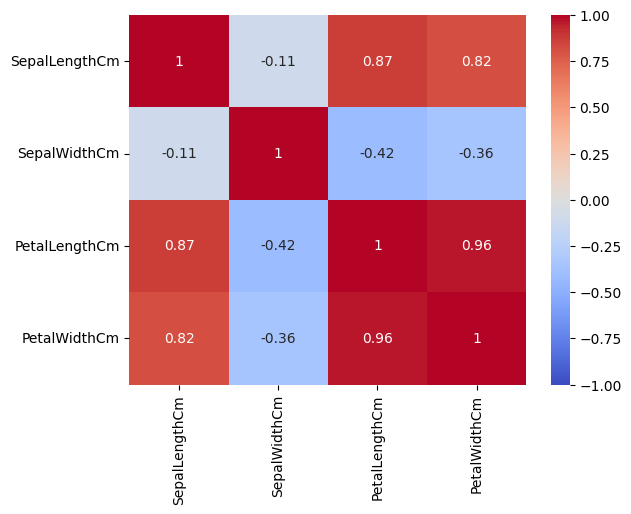

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.heatmap(corr_matrix_df,annot=True,vmin=-1,vmax=1,cmap='coolwarm')
plt.show()

In [15]:
pdf=df.toPandas()
print(pdf.columns)

Index(['Id', 'SepalLengthCm', 'SepalWidthCm', 'PetalLengthCm', 'PetalWidthCm',
       'Species'],
      dtype='object')


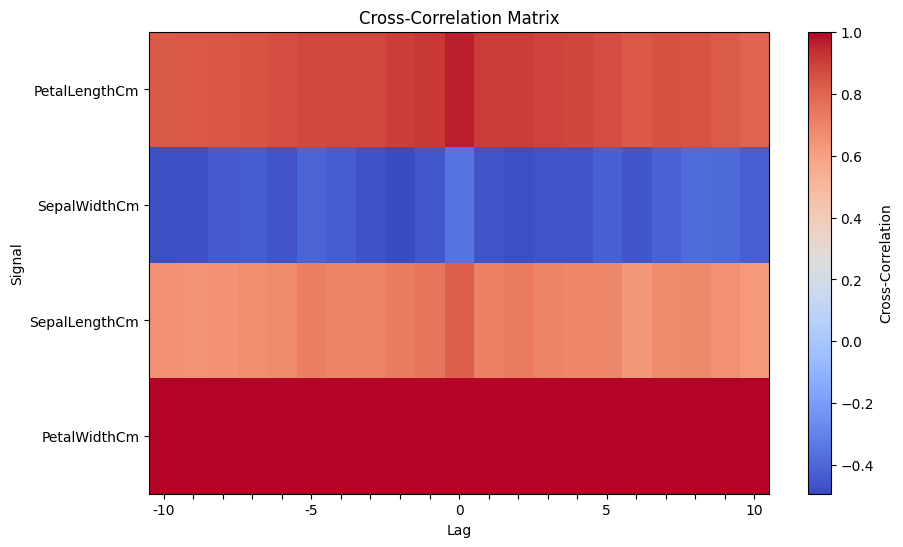

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Assuming you have a DataFrame 'df' with columns 'target' and 'feature1', 'feature2', etc.

def cross_corr(signal1, signal2, lag):
    if lag >= 0:
        corr = signal1.corr(signal2.shift(lag))
    else:
        corr = signal1.shift(-lag).corr(signal2)
    return corr

min_lag = -10
max_lag = 10
lags = range(min_lag, max_lag + 1)

# Specify the lag values for which you want to show tick labels
show_tick_lags = [-10, -5, 0, 5, 10]  # Add more if needed

# List of feature signal column names
feature_columns = ['SepalLengthCm', 'SepalWidthCm', 'PetalLengthCm']  # Add more if needed
signals = ['PetalWidthCm'] + feature_columns

# Initialize a matrix to store cross-correlation values
def lagged_cross_corr(df,signals,target):
    corr_matrix = np.zeros((len(signals), len(lags)))

    for i, target_col in enumerate(signals):
        for j, lag in enumerate(lags):
            if target_col == target:
                signal1 = df[target]
            else:
                signal1 = df[target_col]
            corr = cross_corr(signal1, df[target], lag) if target_col != target else 1.0
            corr_matrix[i, j] = corr
    return corr_matrix

corr_matrix=lagged_cross_corr(pdf,signals,'PetalWidthCm')

plt.figure(figsize=(10, 6))
plt.imshow(corr_matrix, cmap='coolwarm', aspect='auto', origin='lower')
plt.colorbar(label='Cross-Correlation')

# Set tick labels for only the specified lag values
plt.xticks(np.arange(len(lags)), [str(lag) if lag in show_tick_lags else '' for lag in lags])
plt.yticks(np.arange(len(signals)), signals)
plt.xlabel('Lag')
plt.ylabel('Signal')
plt.title('Cross-Correlation Matrix')
plt.show()


In [27]:
pdf

,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,1,5.1,3.5,1.4,0.2,Iris-setosa
1,2,4.9,3.0,1.4,0.2,Iris-setosa
2,3,4.7,3.2,1.3,0.2,Iris-setosa
3,4,4.6,3.1,1.5,0.2,Iris-setosa
4,5,5.0,3.6,1.4,0.2,Iris-setosa
...,...,...,...,...,...,...
145,146,6.7,3.0,5.2,2.3,Iris-virginica
146,147,6.3,2.5,5.0,1.9,Iris-virginica
147,148,6.5,3.0,5.2,2.0,Iris-virginica
148,149,6.2,3.4,5.4,2.3,Iris-virginica


In [39]:
idx = pd.IndexSlice
features_to_correlate = ['SepalLengthCm', 'SepalWidthCm','PetalLengthCm']
correlation_series = pdf[features_to_correlate].rolling(window=10).corr()
correlation_series.loc[idx[:,'SepalLengthCm'],:]

,,SepalLengthCm,SepalWidthCm,PetalLengthCm
0,SepalLengthCm,NaN,NaN,NaN
1,SepalLengthCm,NaN,NaN,NaN
2,SepalLengthCm,NaN,NaN,NaN
3,SepalLengthCm,NaN,NaN,NaN
4,SepalLengthCm,NaN,NaN,NaN
...,...,...,...,...
145,SepalLengthCm,1.0,0.493114,0.479033
146,SepalLengthCm,1.0,0.632911,0.573476
147,SepalLengthCm,1.0,0.657131,0.604598
148,SepalLengthCm,1.0,0.458190,0.425918


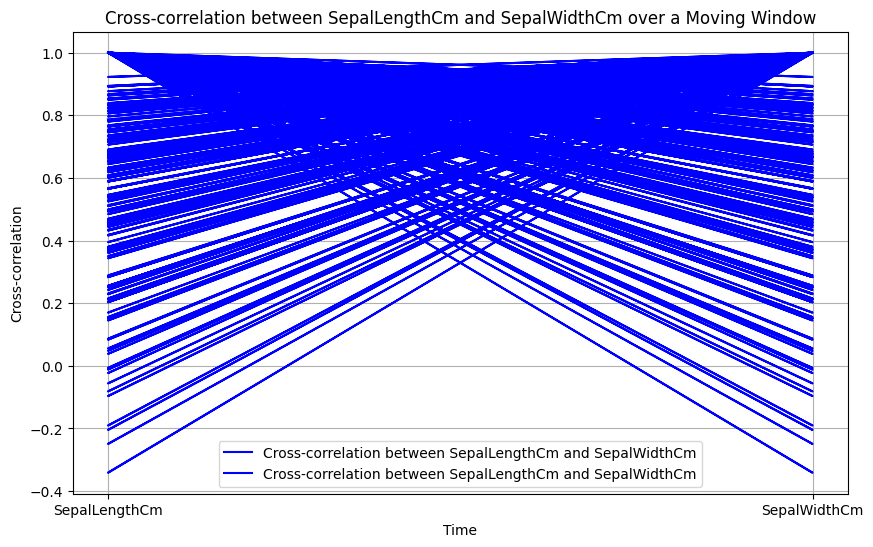

,SepalLengthCm,SepalWidthCm
SepalLengthCm,NaN,NaN
SepalWidthCm,NaN,NaN
SepalLengthCm,NaN,NaN
SepalWidthCm,NaN,NaN
SepalLengthCm,NaN,NaN
...,...,...
SepalWidthCm,0.657131,1.000000
SepalLengthCm,1.000000,0.458190
SepalWidthCm,0.458190,1.000000
SepalLengthCm,1.000000,0.417757


In [36]:


def moving_window_cross_correlation(df, window_size, features_to_correlate):
    """
    Compute cross-correlation between specified features over a moving window and plot the result.

    Parameters:
    - df (pd.DataFrame): The input DataFrame containing the time series data.
    - window_size (int): The size of the moving window.
    - features_to_correlate (list): A list of feature names to compute cross-correlation for.

    Returns:
    - None (plots the result).
    """

    # Compute the cross-correlation between specified features over the moving window
    correlation_series = df[features_to_correlate].rolling(window=window_size).corr()
    # Filter the correlation results to keep only the cross-correlation coefficients
    correlation_result = correlation_series.loc[:, pd.IndexSlice[features_to_correlate[0], features_to_correlate[1]]].droplevel(0, axis=0)

    # Plot the cross-correlation result
    plt.figure(figsize=(10, 6))
    plt.plot(correlation_result, label=f'Cross-correlation between {features_to_correlate[0]} and {features_to_correlate[1]}', color='blue')
    plt.title(f'Cross-correlation between {features_to_correlate[0]} and {features_to_correlate[1]} over a Moving Window')
    plt.xlabel('Time')
    plt.ylabel('Cross-correlation')
    plt.legend()
    plt.grid(True)
    plt.show()
    return correlation_result



# Define the window size and features to correlate
window_size = 10
features_to_correlate = ['SepalLengthCm', 'SepalWidthCm']

# Compute and plot cross-correlation
moving_window_cross_correlation(pdf, window_size, features_to_correlate)
